In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [60]:
df = pd.read_excel('dataset_netflix.xlsx')

## Higienização, Tratamento de Missing e Missing ocultos

In [61]:
df.isna().sum()

show_id            0
type               0
title              0
director        1970
cast               1
country            1
date_added        12
release_year       2
rating             1
duration           1
listed_in          1
description        1
dtype: int64

In [62]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.0,57.0,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [63]:
df = df.copy()

In [64]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].replace({ 'bam': np.nan }) # Missing oculto
df['country'] = df['country'].replace({ 'none': 'Unknown' }) # Missing oculto
df = df.dropna()

## Feature Engineering

#### director

In [65]:
director = df['director']
new_director = [[len(a.split(',')), a.split(',')[0]] for a in director]
df.loc[:, ['qtd_directors', 'first_director']] = new_director

#### duration

In [66]:
duration = df['duration']
new_duration = [b.split()[0] for b in duration]
df.loc[:, 'duration'] = new_duration

#### cast

In [67]:
cast = df['cast']
new_cast = [len(x.split(',')) for x in cast]
df.loc[:, 'qtd_casts'] = new_cast

#### country

In [68]:
country = df['country']
new_country = [[x.split(',')[0], len(x.split(','))] for x in country]
df.loc[:, ['first_country', 'qtd_country']] = new_country

#### rating (target)

In [69]:
df['target'] = df['rating'].apply(lambda x: 1 if x > 85 else 0)

In [70]:
df.target.value_counts()

0    5463
1     190
Name: target, dtype: int64

>Os filmes com nota maior que 80 entram como filmes bons (Vao pro catálogo) => 1 e filmes com menor nota nao entram => 0

>O nivel de nota de classificação depende dos requisitos de negócio

## Ajustando variáveis de interesse no dataframe final

In [71]:
df_final = df[['type', 'duration', 'qtd_directors', 'first_director', 'qtd_casts', 'first_country', 'qtd_country', 'target']].copy()

In [72]:
df_final

,type,duration,qtd_directors,first_director,qtd_casts,first_country,qtd_country,target
0,Movie,90,2,Richard Finn,10,United States,4,0
1,Movie,94,1,Unknown,1,United Kingdom,1,0
2,TV Show,1,1,Unknown,12,United States,1,0
3,TV Show,1,1,Unknown,8,United States,1,0
4,Movie,99,1,Fernando Lebrija,12,United States,1,0
...,...,...,...,...,...,...,...,...
6218,TV Show,2,1,Unknown,5,Cyprus,3,0
6219,TV Show,2,1,Unknown,7,Japan,1,0
6220,TV Show,2,1,Unknown,3,Canada,1,0
6221,TV Show,2,1,Unknown,7,Japan,1,0


#### Transformando campos em variaveis categóricas

In [73]:
encoder = LabelEncoder()
df_final['type'] = encoder.fit_transform(df_final['type'])
df_final['first_director'] = encoder.fit_transform(df_final['first_director'])
df_final['first_country'] = encoder.fit_transform(df_final['first_country'])

In [74]:
df_final.duration = df.duration.astype(int)

In [75]:
df_final.dtypes

type              int32
duration          int32
qtd_directors     int64
first_director    int32
qtd_casts         int64
first_country     int32
qtd_country       int64
target            int64
dtype: object

## Separação de variaveis 

#### Separando variáveis de atributo (features) da variavel classe (target)

In [76]:
X = df_final.drop(['target'], axis =1).values
y = df_final['target']

#### Oversampling para balancear o dataset (expandir as minorias)

In [77]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [78]:
y.value_counts()

1    5463
0    5463
Name: target, dtype: int64

#### Separando variaveis em treino/teste

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [80]:
y_train.value_counts()

1    3848
0    3800
Name: target, dtype: int64

## Treinando vários modelos, para fazer um comparativo e escolher o melhor modelo

In [81]:
models = [
    ("RF", RandomForestClassifier()),
    ("DT", DecisionTreeClassifier()),
    ("KNN-C", KNeighborsClassifier()),
    ("NaiveBayes", GaussianNB())
]

In [82]:
for name, model in models:
    print('\n------------- ' + str(name)+ ' -------------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(metrics.classification_report(y_test, y_pred))


------------- RF -------------
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1663
           1       0.87      0.93      0.90      1615

    accuracy                           0.90      3278
   macro avg       0.90      0.90      0.90      3278
weighted avg       0.90      0.90      0.90      3278


------------- DT -------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1663
           1       0.84      0.92      0.88      1615

    accuracy                           0.87      3278
   macro avg       0.88      0.88      0.87      3278
weighted avg       0.88      0.87      0.87      3278


------------- KNN-C -------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1663
           1       0.81      0.92      0.86      1615

    accuracy                           0.85      3278
   macro avg       0.86      

### Treinando melhor modelo com base nos resultados acima. (Escolhido: o famoso Random Forest)

In [83]:
rf = RandomForestClassifier()

In [84]:
rf.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

### Matriz de confusão

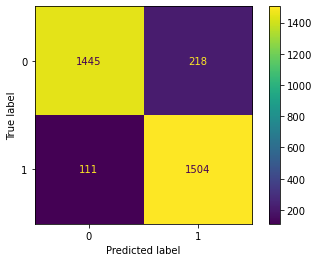

In [85]:
metrics.plot_confusion_matrix(rf, X_test, y_test)

### Precision 

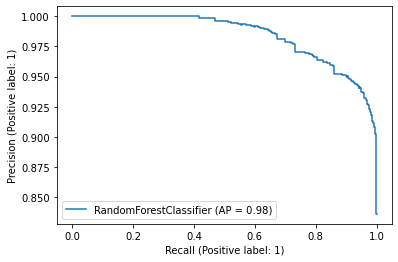

In [86]:
disp = metrics.plot_precision_recall_curve(rf, X_train, y_train)

### ROC Curve

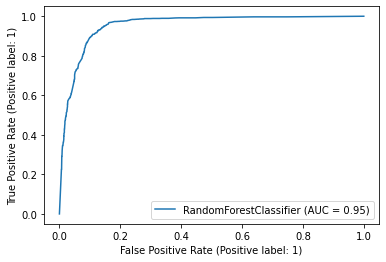

In [87]:
metrics.plot_roc_curve(rf, X_test, y_test)